<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Selected Features (E)</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
# load the best features dictionaries back from the file
with open('../../data/selected_features/feature_set_01_filter_and_wrapper.json', 'r') as json_file:
    selected_features_filter_and_wrapper = json.load(json_file)

with open('../../data/selected_features/feature_set_02_embedded.json', 'r') as json_file:
    selected_features_embedded = json.load(json_file)

In [5]:
# subset the features
pts_sub_fw_features = pts_all_features[selected_features_filter_and_wrapper['TOTAL_PTS'] + ['TOTAL_PTS']]
pts_sub_e_features = pts_all_features[selected_features_embedded['TOTAL_PTS'] + ['TOTAL_PTS']]

pm_sub_fw_features = pm_all_features[selected_features_filter_and_wrapper['PLUS_MINUS'] + ['PLUS_MINUS']]
pm_sub_e_features = pm_all_features[selected_features_embedded['PLUS_MINUS'] + ['PLUS_MINUS']]

res_sub_fw_features = res_all_features[selected_features_filter_and_wrapper['GAME_RESULT'] + ['GAME_RESULT']]
res_sub_e_features = res_all_features[selected_features_embedded['GAME_RESULT'] + ['GAME_RESULT']]

In [6]:
pts_sub_fw_features.head()

,ROLL_HOME_FTM,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_PTS_PAINT,ROLL_AWAY_PTS,ROLL_HOME_PTS_FB,ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED,ROLL_AWAY_DEF_BOXOUTS,ROLL_AWAY_estimatedPace,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_DFG_PCT,ROLL_HOME_AST,ROLL_AWAY_assistToTurnover,ROLL_HOME_OPP_TOV_PCT,ROLL_HOME_estimatedDefensiveRating,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,
2021-10-23,0.955,0.814,0.50,0.577,1.000,0.60,0.20,0.367,0.391,1.000,0.667,0.349,0.840,0.337,185
2021-10-23,0.553,0.763,0.25,0.096,0.581,0.30,0.30,0.458,0.000,0.440,0.000,0.193,0.762,0.199,198
2021-10-23,0.704,0.508,0.70,0.635,0.065,0.75,0.20,0.393,0.565,0.000,0.611,0.705,0.144,0.809,239
2021-10-23,0.352,0.610,0.70,0.250,0.839,0.30,0.10,0.649,0.261,0.964,1.000,0.261,0.519,0.370,232
2021-10-24,0.302,0.203,0.70,1.000,0.548,0.45,0.45,0.598,0.348,0.726,0.833,0.471,0.591,0.003,204


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [7]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_sub_e_features.drop('TOTAL_PTS', axis=1),
    pts_sub_e_features['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 12) (2367,) (691, 12) (691,)


In [8]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 4660.27 seconds


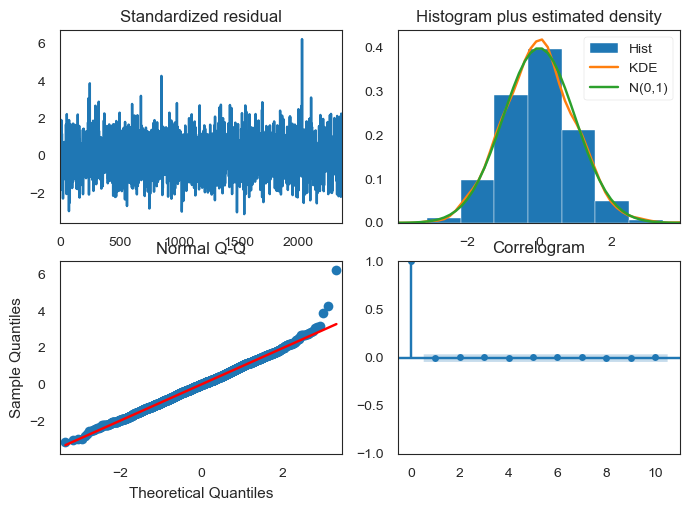

In [9]:
model1.plot_diagnostics();

In [10]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:              SARIMAX(19, 1, 2)   Log Likelihood              -10300.502
Date:                Wed, 10 Apr 2024   AIC                          20671.005
Time:                        00:27:28   BIC                          20872.918
Sample:                             0   HQIC                         20744.514
                               - 2367                                         
Covariance Type:                  opg                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                              0.0113      0.009      1.234      0.217      -0.007       0.029
ROLL_AWAY_DFG_PCT                      2.8692      4.150      0.691      0.489      -5.265      11.003
ROLL_HOME_PTS_PAINT                    4.1075      4.357      0.943      0.346      -4.432      12.647
ROLL_AWAY_assistToTurnover             0.6541      4.502      0.145      0.884      -8.169       9.478
ROLL_AWAY_OPP_PTS_PAINT                4.0991      4.520      0.907      0.364      -4.760      12.958
ROLL_HOME_FGM                          2.3828      9.402      0.253      0.800     -16.045      20.810
ROLL_AWAY_offensiveRating            -34.7200      8.286     -4.190      0.000     -50.960     -18.480
ROLL_HOME_OPP_PTS_PAINT               12.9705      3.608      3.595      0.000       5.900      20.041
ROLL_HOME_estimatedDefensiveRating    19.3349     17.942      1.078      0.281     -15.830      54.500
ROLL_HOME_defensiveRating             -7.4227     20.212     -0.367      0.713     -47.037      32.192
ROLL_HOME_PTS                         14.6875      8.057      1.823      0.068      -1.105      30.480
ROLL_AWAY_FGM                          7.0455      7.128      0.988      0.323      -6.926      21.017
ROLL_AWAY_PTS                         40.5393     10.258      3.952      0.000      20.433      60.645
ar.L1                                 -0.7943      0.684     -1.161      0.245      -2.135       0.546
ar.L2                                 -0.0486      0.033     -1.459      0.145      -0.114       0.017
ar.L3                                 -0.0386      0.035     -1.099      0.272      -0.107       0.030
ar.L4                                  0.0026      0.030      0.086      0.931      -0.056       0.062
ar.L5                                  0.0231      0.031      0.757      0.449      -0.037       0.083
ar.L6                                  0.0508      0.029      1.775      0.076      -0.005       0.107
ar.L7                                  0.0296      0.041      0.724      0.469      -0.050       0.110
ar.L8                                 -0.0181      0.028     -0.638      0.524      -0.074       0.037
ar.L9                                 -0.0216      0.030     -0.722      0.471      -0.080       0.037
ar.L10                                 0.0087      0.029      0.304      0.761      -0.048       0.065
ar.L11                                 0.0176      0.029      0.607      0.544      -0.039       0.074
ar.L12                                -0.0432      0.028     -1.565      0.118      -0.097       0.011
ar.L13                                -0.0677      0.042     -1.594      0.111      -0.151       0.016
ar.L14                                -0.0041      0.034     -0.119      0.905      -0.071       0.062
ar.L15                                 0.0387      0.032      1.223      0.221      -0.023       0.101
ar.L16                                -0.0050   

In [11]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.68 %
Root Mean Squared Error: 19.18


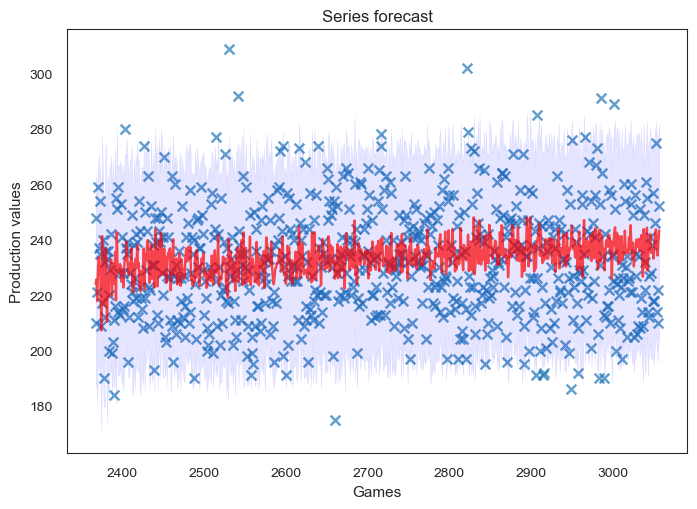

In [12]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_sub_fw_features['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [13]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_sub_e_features.drop('PLUS_MINUS', axis=1),
    pm_sub_e_features['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 14) (2367,) (691, 14) (691,)


In [14]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 23.07 seconds


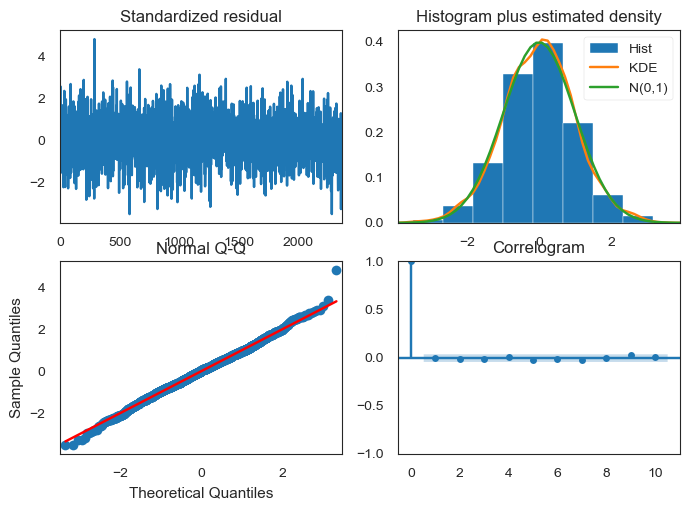

In [15]:
model1.plot_diagnostics();

In [16]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -9559.806
Date:                Wed, 10 Apr 2024   AIC                          19151.611
Time:                        00:27:52   BIC                          19243.921
Sample:                             0   HQIC                         19185.217
                               - 2367                                         
Covariance Type:                  opg                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
ROLL_HOME_netRating                      -26.6874     17.562     -1.520      0.129     -61.107       7.733
ROLL_HOME_PTS_PAINT                        1.5720      3.328      0.472      0.637      -4.952       8.095
ROLL_HOME_effectiveFieldGoalPercentage    -0.4905      3.783     -0.130      0.897      -7.905       6.924
ROLLDIFF_AWAY_PTS                        -10.3410      4.345     -2.380      0.017     -18.857      -1.825
ROLLDIFF_HOME_FG_PCT                      -9.5121      4.310     -2.207      0.027     -17.959      -1.065
ROLLDIFF_AWAY_FT_PCT                      -3.8024      1.784     -2.131      0.033      -7.300      -0.305
ROLLDIFF_HOME_PTS                         20.5666      5.148      3.995      0.000      10.476      30.657
ROLLDIFF_AWAY_AST                          2.5304      2.181      1.160      0.246      -1.744       6.805
ROLL_HOME_CFG_PCT                          5.1020      3.045      1.675      0.094      -0.867      11.070
ROLL_HOME_estimatedNetRating              36.7237     16.004      2.295      0.022       5.356      68.091
ROLL_HOME_CFGA                            -4.0339      2.744     -1.470      0.142      -9.412       1.344
ROLL_AWAY_estimatedNetRating             -33.6389     15.848     -2.123      0.034     -64.700      -2.578
ROLL_AWAY_PIE                            -26.2453     11.578     -2.267      0.023     -48.938      -3.552
ROLL_AWAY_netRating                       45.5078     15.756      2.888      0.004      14.626      76.390
ma.L1                                     -0.0315      0.021     -1.514      0.130      -0.072       0.009
sigma2                                   188.6102      5.088     37.070      0.000     178.638     198.583
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.00
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 134.51 %
Root Mean Squared Error: 14.34


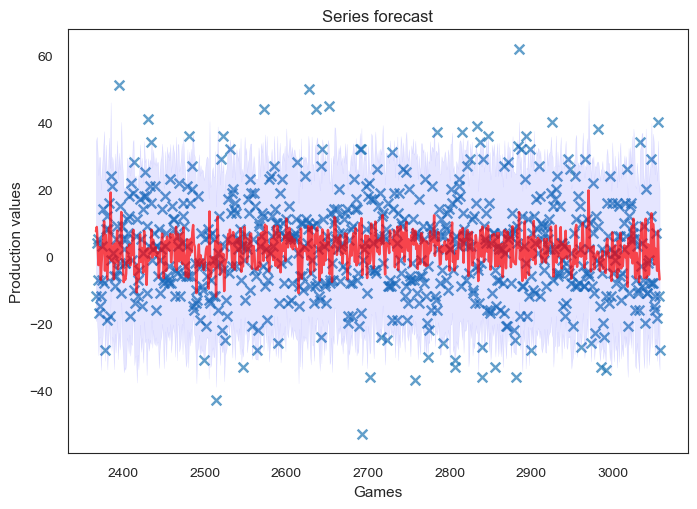

In [18]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pm_sub_fw_features['PLUS_MINUS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();